**Installations**

In [0]:
!pip install --upgrade keras==2.3.1
!pip install --upgrade tensorflow==1.15

Requirement already up-to-date: keras==2.3.1 in /usr/local/lib/python3.6/dist-packages (2.3.1)
     |████████████████████████████████| 412.3MB 31kB/s 
     |████████████████████████████████| 512kB 58.0MB/s 
     |████████████████████████████████| 3.8MB 58.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=02b95a092e95386cc646e08a0492cfc37d3135dd299c78a62b5f8cbbb628acba
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: gast 0.3.3
    

**Imports**

In [0]:
import os, datetime, argparse, csv, itertools, random
from sys import exit
import nltk, tensorflow

import pandas as pd
import numpy as np

from math import exp
from re import sub
from time import time
from random import shuffle

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split as split_data
from sklearn.metrics import classification_report

import keras
import keras.backend as K

from keras import regularizers
from keras.models import Model
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
from keras.activations import softmax
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
import tkinter

matplotlib.use('TkAgg')

from google.colab import drive
from oauth2client.client import GoogleCredentials

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Data Parsing**

In [0]:
# data_file = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/movie_training_data.csv'
# data_file = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/movie_training_data_sumry.csv'
# data_file = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/movie_training_data_combo.csv'
data_file         = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/movie_training_data_synps.csv'
google_embeddings = '/content/gdrive/My Drive/Colab Notebooks/imdb-spoiler-dataset/GoogleNews-vectors-negative300.bin.gz'

rows_count  = 300000
train_ratio = 0.8 # divide into train and validation data
test_ratio  = 0.96 # divide into train and test data
max_len     = 30
vocab_size  = 1
vocab_limit = None

data_name     = 'movie_traning'
sequence_cols = ['sentence_1', 'sentence_2']
score_col     = ['label']

x_train, y_train  = list(), list()
x_val, y_val      = list(), list()
x_test, y_test    = list(), list()

vocab       = set('PAD')
word_to_id  = {'PAD':0}
id_to_word  = {0:'PAD'}

word_to_count = dict()

**Read Data from File**

In [0]:
print('Loading data from file')
data_df = pd.read_csv(data_file, nrows=rows_count)
data_df.head()

Loading data from file


,movie_id,sentence_1,sentence_2,label
0,tt1568346,Note: this is an English-language adaptation o...,"Confusing, unless you have read the book first...",True
1,tt2404435,In this remake of the 1960 film of the same na...,There Were Seven - They Weren't Magnificent Th...,True
2,tt0408236,"Benjamin Barker (Johnny Depp), a skilled barbe...",this movie gave me chills... This movie made m...,True
3,tt3498820,"In 1991, Bucky Barnes (Sebastian Stan), brainw...",One of the best Marvel movies This movie helps...,True
4,tt0109830,The film begins with a feather falling to the ...,Life through a different view! This is a lovel...,True


**Convert text to word list**

In [0]:
def text_to_word_list(text):
  ''' Pre process and convert texts to a list of words '''
  text = str(text)
  text = text.lower()

  # Clean the text
  text = sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
  text = sub(r"what's", "what is ", text)
  text = sub(r"\'s", " ", text)
  text = sub(r"\'ve", " have ", text)
  text = sub(r"can't", "cannot ", text)
  text = sub(r"n't", " not ", text)
  text = sub(r"i'm", "i am ", text)
  text = sub(r"\'re", " are ", text)
  text = sub(r"\'d", " would ", text)
  text = sub(r"\'ll", " will ", text)
  text = sub(r",", " ", text)
  text = sub(r"\.", " ", text)
  text = sub(r"!", " ! ", text)
  text = sub(r"\/", " ", text)
  text = sub(r"\^", " ^ ", text)
  text = sub(r"\+", " + ", text)
  text = sub(r"\-", " - ", text)
  text = sub(r"\=", " = ", text)
  text = sub(r"'", " ", text)
  text = sub(r"(\d+)(k)", r"\g<1>000", text)
  text = sub(r":", " : ", text)
  text = sub(r" e g ", " eg ", text)
  text = sub(r" b g ", " bg ", text)
  text = sub(r" u s ", " american ", text)
  text = sub(r"\0s", "0", text)
  text = sub(r" 9 11 ", "911", text)
  text = sub(r"e - mail", "email", text)
  text = sub(r"j k", "jk", text)
  text = sub(r"\s{2,}", " ", text)

  text = text.split()

  return text

**Vocab Generation**

In [0]:
def generate_vocab():
  print('Generating vocabulary')

  global vocab_size, vocab
  global word_to_id, id_to_word, word_to_count
  global data_df

  stops = set(stopwords.words('english'))

  # Iterate over required sequences of provided dataset
  for index, row in data_df.iterrows():
      # Iterate through the text of both questions of the row
      for col in sequence_cols:
          s2n = []  # Sequences with words replaces with indices
          for word in text_to_word_list(row[col]):
              # Remove unwanted words
              if word in stops:
                  continue

              if word not in vocab:
                  vocab.add(word)
                  word_to_id[word] = vocab_size
                  word_to_count[word] = 1
                  s2n.append(vocab_size)
                  id_to_word[vocab_size] = word
                  vocab_size += 1

              else:
                  word_to_count[word] += 1
                  s2n.append(word_to_id[word])

          # Replace |sequence as word| with |sequence as number| representation
          data_df.at[index, col] = s2n

In [0]:
generate_vocab()
print('data size: ' + str(len(data_df)))

Generating vocabulary
data size: 300000


In [0]:
data_df.head()

,movie_id,sentence_1,sentence_2,label
0,tt1568346,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[625, 626, 627, 266, 248, 628, 629, 630, 631, ...",True
1,tt2404435,"[833, 834, 650, 835, 836, 430, 837, 838, 839, ...","[1057, 4, 1198, 1199, 1200, 893, 1198, 1201, 1...",True
2,tt0408236,"[1234, 1235, 1236, 1237, 1238, 1239, 1240, 124...","[1199, 1486, 1487, 1199, 1488, 1489, 1490, 149...",True
3,tt3498820,"[1581, 1582, 1583, 1584, 1585, 1586, 1587, 158...","[215, 100, 2021, 2022, 1199, 2023, 387, 2024, ...",True
4,tt0109830,"[650, 234, 2062, 1144, 2063, 2064, 2065, 1816,...","[60, 269, 2183, 1547, 2184, 1555, 4, 2185, 675...",True


**Additional Data Pre-processing**

In [0]:
def preprocess_data():
  print('Building training data set')
  
  global x_train, x_val, y_train, y_val
  global x_test, y_test

  data_size = len(data_df)  

  X = data_df[sequence_cols]
  Y = data_df[score_col]

  x_rem, x_test, y_rem, y_test = split_data(X, Y, train_size=test_ratio, stratify=True)
  x_train, x_val, y_train, y_val = split_data(x_rem, y_rem, train_size=train_ratio, stratify=True)

  # Split to lists
  x_train = [x_train[column] for column in sequence_cols]
  x_val = [x_val[column] for column in sequence_cols]
  x_test = [x_test[column] for column in sequence_cols]

  # Convert labels to their numpy representations
  y_train = y_train.values
  y_val = y_val.values
  y_test = y_test.values

In [0]:
preprocess_data()
print('Length X_train: ' + str(len(x_train[0])))
print('Length X_val: ' + str(len(x_val[0])))
print('Length X_test: ' + str(len(x_test[0])))

Building training data set
Length X_train: 230400
Length X_val: 57600
Length X_test: 12000


**Padding sequences**

In [0]:
def pad_seq():
  print('Padding sequences')

  global max_len

  if max_len == 0:
      max_len = max(
          max(len(seq) for seq in x_train[0]),
          max(len(seq) for seq in x_train[1]),
          max(len(seq) for seq in x_val[0]),
          max(len(seq) for seq in x_val[1]),
          max(len(seq) for seq in x_test[0]),
          max(len(seq) for seq in x_test[1]))
      
  # Zero padding
  for dataset, side in itertools.product([x_train, x_val, x_test], [0, 1]):
      if max_len: dataset[side] = pad_sequences(dataset[side], maxlen=max_len)
      else : dataset[side] = pad_sequences(dataset[side])

In [0]:
pad_seq()

Padding sequences


**Embedding google news vectors**

In [0]:
embedding_size = 300 # Dimensionality of Google News' Word2Vec

In [0]:
def get_embedding_matrix(word_index):
  word2vec = KeyedVectors.load_word2vec_format(google_embeddings, binary=True)

  # Prepare Embedding Matrix.
  embedding_matrix = np.zeros((len(word_index)+1, embedding_size))

  for word, i in word_index.items():
  # words not found in embedding index will be all-zeros.
    if word not in word2vec.vocab:
      continue
    embedding_matrix[i] = word2vec.word_vec(word)

  del word2vec
  return embedding_matrix

**Build Embedding**

In [0]:
print('Building Embedding Matrix')
embedding_matrix = get_embedding_matrix(word_to_id)
embedding_size = embedding_matrix.shape[1]

Building Embedding Matrix


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Manhattan LSTM

In [0]:
hidden_size = 50
adadel_learning_rate = 0.66
adam_learning_rate = 0.001
batch_size = 64
num_iters = 30 # number of epochs

PATIENCE = 4
VERBOSE = 1
filepath = '/content/gdrive/My Drive/Colab Notebooks/saved_models_manhtn/lr1-san-adam--{epoch:02d}-{val_loss:.5f}.hdf5'

In [0]:
print('\n')
print('Number of training samples        :', len(x_train[0]))
print('Number of validation samples      :', len(x_val[0]))
print('Number of testing samples         :', len(x_test[0]))
print('Maximum sequence length           :', max_len)
print('\n')



Number of training samples        : 230400
Number of validation samples      : 57600
Number of testing samples         : 12000
Maximum sequence length           : 30




In [0]:
def exponent_neg_manhattan_distance(x, hidden_size=50):
  ''' Helper function for the similarity estimate of the LSTMs outputs '''
  return K.exp(-K.sum(K.abs(x[:,:hidden_size] - x[:,hidden_size:]), axis=1, keepdims=True))

def exponent_neg_cosine_distance(x, hidden_size=50):
  ''' Helper function for the similarity estimate of the LSTMs outputs '''
  leftNorm = K.l2_normalize(x[:,:hidden_size], axis=-1)
  rightNorm = K.l2_normalize(x[:,hidden_size:], axis=-1)
  return K.exp(K.sum(K.prod([leftNorm, rightNorm], axis=0), axis=1, keepdims=True))

In [0]:
opt1 = keras.optimizers.Adadelta(lr=adadel_learning_rate, clipnorm=1.25)
opt2 = keras.optimizers.Adam(lr=adam_learning_rate)

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss', 
                             verbose=VERBOSE,
                             save_best_only=True, 
                             mode='auto')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=PATIENCE,
                               verbose=VERBOSE)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Building model

In [0]:
def get_manhattan_lstm_model(embedding_matrix, embedding_size, lstm_layers, opt):
  embed_layer = Embedding(output_dim=embedding_size, input_dim=vocab_size+1, input_length=max_len, trainable=False)
  embed_layer.build((None,))
  embed_layer.set_weights([embedding_matrix])

  seq_1 = Input(shape=(max_len,), dtype='int32', name='sentence_1')
  seq_2 = Input(shape=(max_len,), dtype='int32', name='sentence_2')

  input_1 = embed_layer(seq_1)
  input_2 = embed_layer(seq_2)

  l1 = LSTM(units=hidden_size)

  l1_out = l1(input_1)
  l2_out = l1(input_2)

  concats = concatenate([l1_out, l2_out], axis=-1)

  main_output = Lambda(exponent_neg_manhattan_distance, output_shape=(1,))(concats)
  model = Model(inputs=[seq_1, seq_2], outputs=[main_output])

  model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
  return model

In [0]:
man_lstm_model = get_manhattan_lstm_model(embedding_matrix, embedding_size, hidden_size, opt2)
man_lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_1 (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
sentence_2 (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 300)      71274600    sentence_1[0][0]                 
                                                                 sentence_2[0][0]                 
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           70200       embedding_1[0][0]          

In [0]:
training_start_time = time()
man_lstm_model_ = man_lstm_model.fit(x_train, 
                                 y_train, 
                                 validation_data=(x_val, y_val),
                                 epochs=num_iters,
                                 callbacks=[checkpoint, early_stopping], 
                                 batch_size=batch_size, 
                                 verbose=1)

print("Training time finished.\n{} epochs in {}".format(num_iters, datetime.timedelta(seconds=time()-training_start_time)))


Train on 230400 samples, validate on 57600 samples
Epoch 1/30
230400/230400 [==============================] - 135s 585us/step - loss: 0.2469 - accuracy: 0.5552 - val_loss: 0.2387 - val_accuracy: 0.5856

Epoch 00001: val_loss improved from inf to 0.23869, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models_manhtn/lr1-san-adam--01-0.23869.hdf5
Epoch 2/30
230400/230400 [==============================] - 136s 592us/step - loss: 0.2339 - accuracy: 0.6049 - val_loss: 0.2333 - val_accuracy: 0.6090

Epoch 00002: val_loss improved from 0.23869 to 0.23331, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models_manhtn/lr1-san-adam--02-0.23331.hdf5
Epoch 3/30
230400/230400 [==============================] - 146s 632us/step - loss: 0.2291 - accuracy: 0.6195 - val_loss: 0.2304 - val_accuracy: 0.6120

Epoch 00003: val_loss improved from 0.23331 to 0.23043, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models_manhtn/lr1-san-adam--03-0.23043.hdf5
Epoc

Load back the checkpointed weights

In [0]:
# Test loss: 0.16497848300933837
# Test accuracy: 0.7634000182151794
# model_path = '/content/gdrive/My Drive/Colab Notebooks/saved_models_manhtn/lr1-san-adam--12-0.17972.hdf5'
# model_path = '/content/gdrive/My Drive/Colab Notebooks/saved_models_manhtn/lr1-san-adam--11-0.18004.hdf5')

# stratified model
model_path = '/content/gdrive/My Drive/Colab Notebooks/saved_models_manhtn/lr1-san-adam--12-0.22684.hdf5'

man_lstm_model.load_weights(model_path)

Plotting accuracy of the Manhattan LSTM model

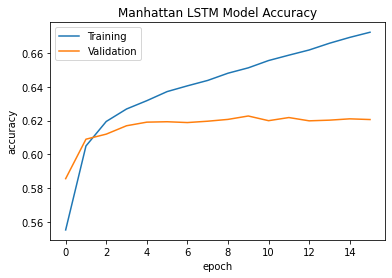

In [0]:
plt.figure(1)
plt.plot(man_lstm_model_.history['accuracy'])
plt.plot(man_lstm_model_.history['val_accuracy'])
plt.title('Manhattan LSTM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show();

Plotting loss of the Manhattan LSTM model

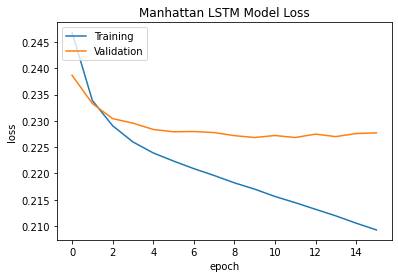

In [0]:
plt.figure(2)
plt.plot(man_lstm_model_.history['loss'])
plt.plot(man_lstm_model_.history['val_loss'])
plt.title('Manhattan LSTM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show();

Testing the model

In [0]:
score = man_lstm_model.evaluate(x_test,
                            y_test,
                            batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12000/12000 [==============================] - 2s 179us/step
Test loss: 0.22973136945565542
Test accuracy: 0.612500011920929


In [0]:
y_pred = man_lstm_model.predict(x_test)
y_pred = [0 if x < 0.5 else 1 for x in y_pred]
y_test_1hot = [0 if not x else 1 for x in y_test]
print(classification_report(y_test_1hot, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.57      0.60      6013
           1       0.60      0.65      0.62      5987

    accuracy                           0.61     12000
   macro avg       0.61      0.61      0.61     12000
weighted avg       0.61      0.61      0.61     12000



# ESIM Model

In [0]:
print('\n')
print('Number of training samples   :', len(x_train[0]))
print('Number of validation samples :', len(x_val[0]))
print('Maximum sequence length      :', max_len)
print('\n')



Number of training samples   : 230400
Number of validation samples : 57600
Maximum sequence length      : 30




In [0]:
print(embedding_matrix.shape)
print(vocab_size+1)

(237582, 300)
237582


In [0]:
## ESIM
def StaticEmbedding(embedding_matrix):
    in_dim, out_dim = embedding_matrix.shape
    return Embedding(in_dim, out_dim, weights=[embedding_matrix], trainable=False)

def subtract(input_1, input_2):
    minus_input_2 = Lambda(lambda x: -x)(input_2)
    return add([input_1, minus_input_2])

def aggregate(input_1, input_2, num_dense=300, dropout_rate=0.5):
    feat1 = concatenate([GlobalAvgPool1D()(input_1), GlobalMaxPool1D()(input_1)])
    feat2 = concatenate([GlobalAvgPool1D()(input_2), GlobalMaxPool1D()(input_2)])
    x = concatenate([feat1, feat2])
    x = BatchNormalization()(x)
    x = Dense(num_dense, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(num_dense, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    return x    

def align(input_1, input_2):
    attention = Dot(axes=-1)([input_1, input_2])
    w_att_1 = Lambda(lambda x: keras.activations.softmax(x, axis=1))(attention)
    w_att_2 = Permute((2,1))(Lambda(lambda x: keras.activations.softmax(x, axis=2))(attention))
    in1_aligned = Dot(axes=1)([w_att_1, input_1])
    in2_aligned = Dot(axes=1)([w_att_2, input_2])
    return in1_aligned, in2_aligned

def build_model(embedding_matrix, num_class=1, max_length=30, lstm_dim=300): # inpt, 
    q1 = Input(shape=(max_length,), dtype='int32', name='q1')
    q2 = Input(shape=(max_length,), dtype='int32', name='q2')
    # q1, q2 = inpt
    
    # Embedding
    embedding = StaticEmbedding(embedding_matrix)
    q1_embed = BatchNormalization(axis=2)(embedding(q1))
    q2_embed = BatchNormalization(axis=2)(embedding(q2))

    # Encoding
    encode = Bidirectional(LSTM(lstm_dim, return_sequences=True))
    q1_encoded = encode(q1_embed)
    q2_encoded = encode(q2_embed)
    
    # Alignment
    q1_aligned, q2_aligned = align(q1_encoded, q2_encoded)
    
    # Compose
    q1_combined = concatenate([q1_encoded, q2_aligned, subtract(q1_encoded, q2_aligned), multiply([q1_encoded, q2_aligned])])
    q2_combined = concatenate([q2_encoded, q1_aligned, subtract(q2_encoded, q1_aligned), multiply([q2_encoded, q1_aligned])]) 
    compose = Bidirectional(LSTM(lstm_dim, return_sequences=True))
    q1_compose = compose(q1_combined)
    q2_compose = compose(q2_combined)
    
    # Aggregate
    x = aggregate(q1_compose, q2_compose)
    x = Dense(num_class, activation='sigmoid')(x)
    model = Model(inputs=[q1, q2], outputs=x)
    
    return model

In [0]:
# ESIM
adam_lr           = 0.0006
adadel_lr         = 0.5
BATCH_SIZE        = 64
NUM_EPOCHS        = 16
STEPS_PER_EPOCH   = 200
VALIDATION_STEPS  = 200
VERBOSE           = 1
PATIENCE          = 4
mse, bce          = 'mean_squared_error', 'binary_crossentropy'
esim_model        = build_model(embedding_matrix, max_length=max_len)
opt1              = Adadelta(lr=adadel_lr, clipnorm=1.5)
opt2              = Adam(lr=adam_lr)
filepath          = '/content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-finalmodel-{epoch:02d}-{val_loss:.5f}.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss', 
                             verbose=VERBOSE,
                             save_best_only=True, 
                             mode='auto')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=PATIENCE,
                               verbose=VERBOSE)

In [0]:
esim_model.compile(optimizer=opt2, loss=mse, metrics=['accuracy'])
esim_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q1 (InputLayer)                 (None, 30)           0                                            
__________________________________________________________________________________________________
q2 (InputLayer)                 (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 300)      71274600    q1[0][0]                         
                                                                 q2[0][0]                         
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 30, 300)      1200        embedding_2[0][0]          

In [0]:
training_start_time = time()

esim_model_ = esim_model.fit(x_train,
                             y_train, 
                             validation_data=(x_val, y_val),
                             epochs=NUM_EPOCHS,  
                             callbacks=[checkpoint, early_stopping],
                             batch_size=BATCH_SIZE, 
                             class_weight={True:1.25, False: 0.75},
                             verbose=VERBOSE)

print("Training time finished.\n{} epochs in {}".format(NUM_EPOCHS, datetime.timedelta(seconds=time()-training_start_time)))

Train on 230400 samples, validate on 57600 samples
Epoch 1/16
230400/230400 [==============================] - 2868s 12ms/step - loss: 0.2281 - accuracy: 0.5582 - val_loss: 0.2378 - val_accuracy: 0.5857

Epoch 00001: val_loss improved from inf to 0.23779, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-finalmodel-01-0.23779.hdf5
Epoch 2/16
230400/230400 [==============================] - 2912s 13ms/step - loss: 0.2130 - accuracy: 0.5864 - val_loss: 0.2395 - val_accuracy: 0.5959

Epoch 00002: val_loss did not improve from 0.23779
Epoch 3/16
230400/230400 [==============================] - 2870s 12ms/step - loss: 0.2049 - accuracy: 0.6120 - val_loss: 0.2303 - val_accuracy: 0.6001

Epoch 00003: val_loss improved from 0.23779 to 0.23030, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-finalmodel-03-0.23030.hdf5
Epoch 4/16
230400/230400 [==============================] - 2908s 13ms/step - loss: 0.1908 - accura

In [0]:
plt.figure(1)
plt.plot(esim_model_.history['accuracy'])
plt.plot(esim_model_.history['val_accuracy'])
plt.title('ESIM Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show();

In [0]:
plt.figure(2)
plt.plot(esim_model_.history['loss'])
plt.plot(esim_model_.history['val_loss'])
plt.title('ESIM Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show();

In [0]:
# bestmodel='/content/gdrive/My Drive/Colab Notebooks/saved_models_prat/lr4-bs-32-weights-improvement2-04-0.54115.hdf5'
# bestmodel='/content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-weights-03-0.18132.hdf5'
bestmodel='/content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-weights-01-0.15774.hdf5' # adam 0.0003
# bestmodel='/content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-new-weights-04-0.17868.hdf5'. # adaddelta 0.5 
# bestmodel='/content/gdrive/My Drive/Colab Notebooks/saved_models_prat/adam-e3-bs-64-finalmodel-03-0.17719.hdf5' # adam 0.0006 last

esim_model.load_weights(bestmodel)

In [0]:
score = esim_model.evaluate(x_test,
                            y_test,
                            batch_size=BATCH_SIZE)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
y_pred = esim_model.predict(x_test)
y_pred = [0 if x < 0.5 else 1 for x in y_pred]
y_test_1hot = [0 if not x else 1 for x in y_test]
print(classification_report(y_test_1hot, y_pred))